# Simulated time series

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/joepatmckenna/fem/master?filepath=doc%2Fnotebooks%2Fdiscrete%2F01_simulated_time_series.ipynb)

In this example, we generate discrete time series data from a stochastic model with known parameters.  After generating the data, we demonstrate how to use `FEM` to infer the model parameters.

We start by importing the necessary packages and ensuring that matplotlib places its output in the notebook:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fem
%matplotlib inline

We consider a system of $n$ variables $x_i(t)$ that each take on values from the first $m$ nonnegative integers over time, i.e. $x_i(t)\in\{0,\ldots,m-1\}$ for all $i=1,\ldots,n$ and $t=1,\ldots,\ell$. The state of variable $i$ at time $t$, $x_i(t)$, is represented by the one-hot encoding $\sigma_i(t)\in\{0,1\}^m$ with components $$e_j^T\sigma_i(t)=\begin{cases}1&\text{ if }x_i(t)=j-1\\0&\text{ otherwise}\end{cases},\quad j=1,\ldots,m$$ while the state of the system at time $t$ is represented by their concatenation $\sigma(t)=\begin{pmatrix}\sigma_1(t)&\cdots&\sigma_n(t)\end{pmatrix}^T$.

In the model that we consider, the probability of $x_i(t+1)=j$ depends on $\sigma(t)$ and the model parameters $W\in\mathbb{R}^{mn\times mn}$

$$p_W(x_{i}(t+1)=j~|~\sigma(t)) = {\exp e_{(i-1)m + j}^TW\sigma(t) \over \sum_{k=1}^m\exp e_{(i-1)m+k}^TW\sigma(t)},\quad j=1,\ldots,m$$

according to the Boltzmann distribution.

The `FEM` package implements a helper function `fem.discrete.model_parameters` for generating random model parameters for the above model. In this case, we restrict each variable to taking the same number of states as all the other variables by passing an integer `m` to the function, though the function supports `m` an iterable of length `n` that specifies the number of states per variable. By default, the parameters in `w` are sampled from a normal distribution with mean 0 and variance $1/\sqrt{mn}$ (using optional arguments `dist=np.random.normal` and `dist_par=(0, 1/np.sqrt(m*n))`). The model parameters `w` are returned as a dictionary with keys corresponding to degrees of the model (`degs=[1]` by default, see [FEM for discrete data](../../discrete.rst) for more information).

In [2]:
n, m = 10, 3
w = fem.discrete.simulate.model_parameters(n, m)

We plot `w` as an image and flatten out `w` to a 1D array and plot the distribution:

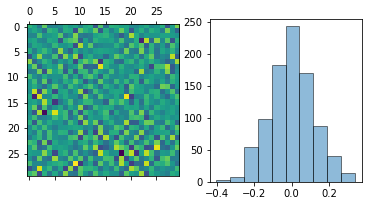

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].matshow(w[1])
w_flat = np.hstack([wi for wi in w.itervalues()]).flatten()
hist = ax[1].hist(w_flat, bins=n, ec='k', alpha=0.5)

Next, we generate time series data given the model parameters `w`. The `FEM` package implements a helper function `fem.discrete.simulate.time_series` for generating time series data according to the model above. We specify with the parameter `o` that the number of time points to be returned is $o$ times the number of model parameters ($(mn)^2$ in this case). We could instead specify a number of time points with the optional argument `l`. The columns of the returned array store the values of the system at different times $t$.

In [4]:
x = fem.discrete.simulate.time_series(w, n, m, o=4.0)

Let's examine the generated data. Each variable takes `m=3` unique states as expected. By default, these are symbolized by the first nonnegative integers. The average of each variable is approximately 1.

In [5]:
tab = []
for i in range(n):
    tab.append([np.unique(x[i]), x[i].mean()])
pd.DataFrame(data=tab,
             columns=['states', 'average'],
             index=['$x_{%i}$' % (i,) for i in 1+np.arange(n)])

,states,average
$x_{1}$,"[0, 1, 2]",1.015000
$x_{2}$,"[0, 1, 2]",0.988889
$x_{3}$,"[0, 1, 2]",0.992222
$x_{4}$,"[0, 1, 2]",0.999167
$x_{5}$,"[0, 1, 2]",1.021389
$x_{6}$,"[0, 1, 2]",1.032222
$x_{7}$,"[0, 1, 2]",0.981944
$x_{8}$,"[0, 1, 2]",0.981111
$x_{9}$,"[0, 1, 2]",0.983333
$x_{10}$,"[0, 1, 2]",0.985278


Plotting the first 100 time points, there is no obvious pattern to the naked eye:

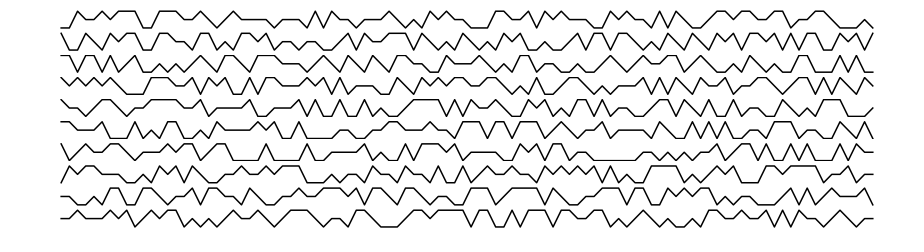

In [6]:
fig, ax = plt.subplots(n, 1, figsize=(16,4))
for i in range(n):
    ax[i].plot(x[i, :100], 'k-')
    ax[i].axis('off')

We can however determine the model that generated the above data using `FEM`. We start by splitting the data `x` into two sets `x1`, which contains all but the last time point, and `x2`, which contains all but the first time point. Next, we use the `fem.discrete.fit.fit` function to infer the `w` that is used to map `x1` to `x2`. In this case, we require a fixed number of iterations of the method with the `iters` argument.

The fit function returns the inferred parameters (`w_fit` below) as a dictionary with keys `degs` (`degs=[1]` by default). It also returns the discrepancy (`disc` below) for each variable defined by

$$d_i={1\over\ell-1}\sum_{t=1}^{\ell-1}\sqrt{\sum_{j=1}^m(1-e_j^T\sigma_i(t+1))~p_W(x_i(t+1)=j~|~\sigma(t))^2}$$.

The lists in `disc` are running values of $d_i$ as $W$ is updated by the iteration.

In [7]:
mod = fem.discrete.fit.model()
x1, x2 = x[:, :-1], x[:, 1:]
mod.fit(x1, x2)

We make a scatter plot of the inferred `w_fit` model parameters versus the true `w` model parameters. Since, the points are scattered around the line with slope 1 that passes through the origin, we confirm that the algorithm accurately recovers the true model parameters.

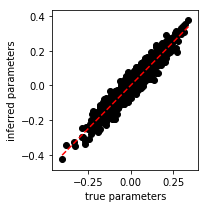

In [8]:
w_fit_flat = np.hstack([wi for wi in mod.w.itervalues()]).flatten()

fig = plt.figure(figsize=(3,3))
ax = plt.gca()

ax.scatter(w_flat, w_fit_flat, c='k')
lo, hi = w_flat.min(), w_flat.max()
grid = np.linspace(lo, hi)
ax.plot(grid, grid, 'r--')
ax.set_xlabel('true parameters')
ax.set_ylabel('inferred parameters')
    
plt.tight_layout()
plt.show()

In [9]:
x2_prediction, p = mod.predict(x1)

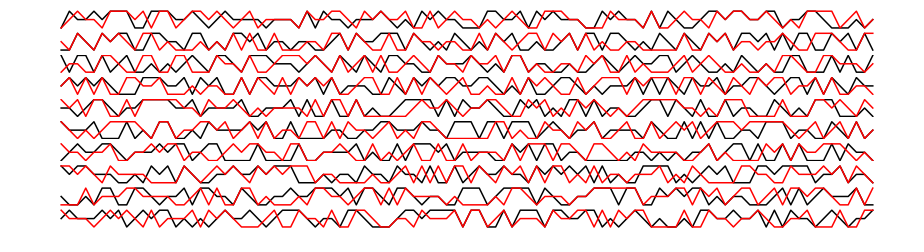

In [10]:
fig, ax = plt.subplots(n, 1, figsize=(16, 4))
for i in range(n):
    ax[i].plot(x2[i, :100], 'k-')
    ax[i].plot(x2_prediction[i, :100], 'r-')
    ax[i].axis('off')
plt.show()